In [124]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn.datasets
from sklearn.metrics import classification_report



def apply_lda(U, D):
    return U.T @ D

def calc_SB_SW(D, L):
    NL = np.unique(L)
    print(L)
    U = D.mean(1, keepdims=True)
    UC = []
    NC = []

    for l in L:
        UC.append(D[:, (L == l)].mean(1))
        NC.append(np.count_nonzero(L == l))

    UC = np.array(UC).T

    SBsum = 0
    for i, l in enumerate(NL):
        SBsum += NC[i] * (UC[:, [i]] - U) @ (UC[:, [i]] - U).T

    SB = SBsum/D.shape[1]

    D_by_class = [D[:, (L == l)] for i, l in enumerate(NL)]
    SWsum = 0

    for i, l in enumerate(NL):
        SWsum += (D_by_class[i] - UC[:, [i]]) @ (D_by_class[i] - UC[:, [i]]).T

    SW = SWsum/D.shape[1]
    
    return (SB, SW)
def compute_lda_JointDiag(D, L, m):

    Sb, Sw = calc_SB_SW(D, L)

    U, s, _ = np.linalg.svd(Sw)
    P = U @ np.diag(1.0/(s**0.5)) @ U.T

    Sb2 = P @ Sb @ P.T
    U2, s2, _ = np.linalg.svd(Sb2)

    P2 = U2[:, 0:m]
    return P.T @ P2

trainData = np.genfromtxt('./trainDataDigits.txt', delimiter=',')
print(trainData.shape)

D = np.array(trainData[:,0:trainData.shape[1]-1], dtype="float64").T
L = np.array(trainData[:,trainData.shape[1]-1], dtype="float64")

def logpdf_GAU_ND(X, mu, C):
    """
    Calculates the log of the probability density function of a multivariate Gaussian distribution.
    """
    _, C_logdet = np.linalg.slogdet(C)
    C_inv = np.linalg.inv(C)
    dotp = 0.5 * np.sum((X - mu) * (C_inv @ (X - mu)), axis=0)

    return -C.shape[0]/2 * np.log(2*np.pi) - 0.5 * C_logdet - dotp


def split_train(D, L, percentageTraining, seed=0):
    nTrain = int(D.shape[1] * percentageTraining)
    np.random.seed(seed)
    shuffledIndices = np.random.permutation(D.shape[1])

    DTR = D[:, shuffledIndices[0:nTrain]]
    LTR = L[shuffledIndices[0:nTrain]]

    DVAL = D[:, shuffledIndices[nTrain:]]
    LVAL = L[shuffledIndices[nTrain:]]

    return (DTR, LTR), (DVAL, LVAL)

def calc_params(D):
    U = D.mean(axis=1, keepdims=True)
    z = D - U
    C = z @ z.T / D.shape[1]

    return U, C



def llr(DTR, LTR, DVAL, LVAL, show_plots=True):
    print(f"Training set: {DTR.shape}, Validation set: {DVAL.shape}")

    (mu0, C0) = calc_params(DTR[:, (LTR == 0)])
    (mu1, C1) = calc_params(DTR[:, (LTR == 1)])

    llr = logpdf_GAU_ND(DVAL, mu1, C1) - logpdf_GAU_ND(DVAL, mu0, C0)
    classes = np.unique(LTR)

    t = -np.log(1/2/(1/2))

    # Predict labels based on the threshold
    predictions = np.zeros_like(LVAL)
    predictions[llr > t] = 1

    # Print classification report
    if show_plots:
        print("Classification Report (Standard LLR):")
        print(classification_report(LVAL, predictions))

        # Plot the log-likelihood ratios
        plt.figure(figsize=(10, 6))
        plt.hist(llr[LVAL == 0], bins=50, alpha=0.5, label='Class 0')
        plt.hist(llr[LVAL == 1], bins=50, alpha=0.5, label='Class 1')
        plt.axvline(x=t, color='red', linestyle='--', label='Threshold')
        plt.legend()
        plt.title('Log-Likelihood Ratio Distribution')
        plt.xlabel('Log-Likelihood Ratio')
        plt.ylabel('Count')
        plt.grid(True)
        plt.show()

    error_rate = np.mean((llr > t) != (LVAL == 1))
    if show_plots:
        print(f"Error rate: {error_rate:.4f}")

    # Calculate additional metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(LVAL, predictions)
    precision = precision_score(LVAL, predictions)
    recall = recall_score(LVAL, predictions)
    f1 = f1_score(LVAL, predictions)
    
    metrics = {
        'name': 'Standard LLR',
        'error_rate': error_rate,
    }
    
    return DTR, LTR, DVAL, LVAL, t, metrics


(6000, 7)


In [125]:
def llr_tied(DTR, LTR, DVAL, LVAL, show_plots=True):
    def params_func(DTR, LTR):
        params_by_class = []
        C_tied = np.zeros((DTR.shape[0], DTR.shape[0]))
        for l in [0, 1]:
            Dl = DTR[:, (LTR == l)]
            U = Dl.mean(axis=1, keepdims=True)
            z = Dl - U
            C_tied += z @ z.T
            params_by_class.append((U, 0))
        C_tied = C_tied / DTR.shape[1]
        for l in range(len(params_by_class)):
            params_by_class[l] = (params_by_class[l][0], C_tied)
        return params_by_class
    [(mu0, C0), (mu1, C1)] = params_func(DTR, LTR)

    llr = logpdf_GAU_ND(DVAL, mu1, C1) - logpdf_GAU_ND(DVAL, mu0, C0)
    classes = np.unique(LTR)

    t = -np.log(1/2/(1/2))

    # Predict labels based on the threshold
    predictions = np.zeros_like(LVAL)
    predictions[llr > t] = 1

    # Print classification report
    if show_plots:
        print("Classification Report (Tied LLR):")
        print(classification_report(LVAL, predictions))

        # Plot the log-likelihood ratios
        plt.figure(figsize=(10, 6))
        plt.hist(llr[LVAL == 0], bins=50, alpha=0.5, label='Class 0')
        plt.hist(llr[LVAL == 1], bins=50, alpha=0.5, label='Class 1')
        plt.axvline(x=t, color='red', linestyle='--', label='Threshold')
        plt.legend()
        plt.title('Log-Likelihood Ratio Distribution (Tied)')
        plt.xlabel('Log-Likelihood Ratio')
        plt.ylabel('Count')
        plt.grid(True)
        plt.show()

    error_rate = np.mean((llr > t) != (LVAL == 1))
    if show_plots:
        print(f"Error rate: {error_rate:.4f}")

    metrics = {
        'name': 'Tied LLR',
        'error_rate': error_rate,
    }
    
    return metrics

In [126]:
def llr_naive_bayes(DTR, LTR, DVAL, LVAL, show_plots=True):
    def calc_params_naive(D):
        U = D.mean(axis=1, keepdims=True)
        z = D - U
        C = z @ z.T / D.shape[1]

        return U, C * np.eye(C.shape[0])
    
    (mu0, C0) = calc_params_naive(DTR[:, (LTR == 0)])
    (mu1, C1) = calc_params_naive(DTR[:, (LTR == 1)])
    
    llr = logpdf_GAU_ND(DVAL, mu1, C1) - logpdf_GAU_ND(DVAL, mu0, C0)

    t = -np.log(1/2/(1/2))

    # Predict labels based on the threshold
    predictions = np.zeros_like(LVAL)
    predictions[llr > t] = 1

    # Print classification report
    if show_plots:
        print("Classification Report (Naive Bayes):")
        print(classification_report(LVAL, predictions))

        # Plot the log-likelihood ratios
        plt.figure(figsize=(10, 6))
        plt.hist(llr[LVAL == 0], bins=50, alpha=0.5, label='Class 0')
        plt.hist(llr[LVAL == 1], bins=50, alpha=0.5, label='Class 1')
        plt.axvline(x=t, color='red', linestyle='--', label='Threshold')
        plt.legend()
        plt.title('Log-Likelihood Ratio Distribution (Naive Bayes)')
        plt.xlabel('Log-Likelihood Ratio')
        plt.ylabel('Count')
        plt.grid(True)
        plt.show()

    error_rate = np.mean((llr > t) != (LVAL == 1))
    if show_plots:
        print(f"Error rate: {error_rate:.4f}")
        
    # Calculate additional metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    metrics = {
        'name': 'Naive Bayes LLR',
        'error_rate': error_rate,
    }
    
    return metrics

In [127]:
# Function to collect results and display in a table
def run_all_classifiers(DTR, LTR, DVAL, LVAL, name="Full dataset", show_plots=False):
    print(f"\n===== Running all classifiers on {name} ===== ")
    print(f"Features: {D.shape[0]}")
    
    # Run all classifiers and collect results
    _, _, _, _, _, std_llr_metrics = llr(DTR, LTR, DVAL, LVAL, show_plots=show_plots)
    tied_llr_metrics = llr_tied(DTR, LTR, DVAL, LVAL, show_plots=show_plots)
    naive_bayes_metrics = llr_naive_bayes(DTR, LTR, DVAL, LVAL, show_plots=show_plots)
    
    # Create results table
    results = {
        'dataset': name,
        'n_features': D.shape[0],
        'classifiers': [std_llr_metrics, tied_llr_metrics, naive_bayes_metrics]
    }
    
    # Print results as a formatted table
    print("\nClassifier Results:")
    print("-" * 80)
    print(f"{'Classifier':<15} | {'Error Rate':^10}")
    print("-" * 80)
    
    for clf in results['classifiers']:
        print(f"{clf['name']:<15} | {clf['error_rate']:^10.4f}")
    print("-" * 80)
    
    return results

In [134]:
(DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0)


# Run classifiers on full dataset
full_results = run_all_classifiers(DTR, LTR, DVAL, LVAL, "Full dataset (all features)")

# Run classifiers on first 4 features only
D_subset = D[:4, :]
(DTR_sub, LTR_sub), (DVAL_sub, LVAL_sub) = split_train(D_subset, L, 2.0/3.0)

subset_results4 = run_all_classifiers(DTR_sub, LTR_sub, DVAL_sub, LVAL_sub, "First 4 features only")

D_subset = D[0:2, :]
(DTR_sub, LTR_sub), (DVAL_sub, LVAL_sub) = split_train(D_subset, L, 2.0/3.0)

subset_results1_2 = run_all_classifiers(DTR_sub, LTR_sub, DVAL_sub, LVAL_sub, "1-2 features only")


D_subset = D[2:4, :]
(DTR_sub, LTR_sub), (DVAL_sub, LVAL_sub) = split_train(D_subset, L, 2.0/3.0)

subset_results3_4 = run_all_classifiers(DTR_sub, LTR_sub, DVAL_sub, LVAL_sub, "3-4 features only")

# With pca



def compute_PCA(D, L, m=2):
    u = D.mean(axis=1, keepdims=True)
    DC = D - u
    C = 1/D.shape[1]*DC@DC.T
    U, s, Vh = np.linalg.svd(C)
    P = U[:, 0:m]
    return P


    
# Function to collect results and display in a table
def run_all_classifiers_PCA(DTR, LTR, DVAL, LVAL, L, name="Full dataset", show_plots=False):
    print(f"\n===== Running all classifiers on {name} ===== ")
    print(f"Features: {D.shape[0]}")
    
    # Run all classifiers and collect results
    _, _, _, _, _, std_llr_metrics = llr(DTR, LTR, DVAL, LVAL, show_plots=show_plots)
    tied_llr_metrics = llr_tied(DTR, LTR, DVAL, LVAL, show_plots=show_plots)
    naive_bayes_metrics = llr_naive_bayes(DTR, LTR, DVAL, LVAL, show_plots=show_plots)
    
    # Create results table
    results = {
        'dataset': name,
        'n_features': D.shape[0],
        'classifiers': [std_llr_metrics, tied_llr_metrics, naive_bayes_metrics]
    }
    
    # Print results as a formatted table
    print("\nClassifier Results:")
    print("-" * 80)
    print(f"{'Classifier':<15} | {'Error Rate':^10}")
    print("-" * 80)
    
    for clf in results['classifiers']:
        print(f"{clf['name']:<15} | {clf['error_rate']:^10.4f}")
    print("-" * 80)
    
    return results

pca_results = []
for m in range(1, 7):
    P = compute_PCA(DTR, LTR, m)
    DTR_pca = np.dot(P.T, DTR)
    DVAL_pca = np.dot(P.T, DVAL)

    pca_results.append((run_all_classifiers_PCA(DTR_pca, LTR, DVAL_pca, LVAL, f"After PCA {m}"),f"After PCA {m}" ))




===== Running all classifiers on Full dataset (all features) ===== 
Features: 6
Training set: (6, 4000), Validation set: (6, 2000)

Classifier Results:
--------------------------------------------------------------------------------
Classifier      | Error Rate
--------------------------------------------------------------------------------
Standard LLR    |   0.0700  
Tied LLR        |   0.0930  
Naive Bayes LLR |   0.0720  
--------------------------------------------------------------------------------

===== Running all classifiers on First 4 features only ===== 
Features: 6
Training set: (4, 4000), Validation set: (4, 2000)

Classifier Results:
--------------------------------------------------------------------------------
Classifier      | Error Rate
--------------------------------------------------------------------------------
Standard LLR    |   0.0795  
Tied LLR        |   0.0950  
Naive Bayes LLR |   0.0765  
---------------------------------------------------------------

# Covariances

# Results Comparison

Let's compare the performance of all classifiers across different feature sets:

         Feature Set       Classifier  Error Rate
0       All Features     Standard LLR        7.00
1       All Features         Tied LLR        9.30
2       All Features  Naive Bayes LLR        7.20
3   First 4 Features     Standard LLR        7.95
4   First 4 Features         Tied LLR        9.50
5   First 4 Features  Naive Bayes LLR        7.65
6       1_2 Features     Standard LLR       36.50
7       1_2 Features         Tied LLR       49.45
8       1_2 Features  Naive Bayes LLR       36.30
9       3_4 Features     Standard LLR        9.45
10      3_4 Features         Tied LLR        9.40
11      3_4 Features  Naive Bayes LLR        9.45
12       After PCA 1     Standard LLR        9.25
13       After PCA 1         Tied LLR        9.35
14       After PCA 1  Naive Bayes LLR        9.25
15       After PCA 2     Standard LLR        8.80
16       After PCA 2         Tied LLR        9.25
17       After PCA 2  Naive Bayes LLR        8.85
18       After PCA 3     Standard LLR        8.80


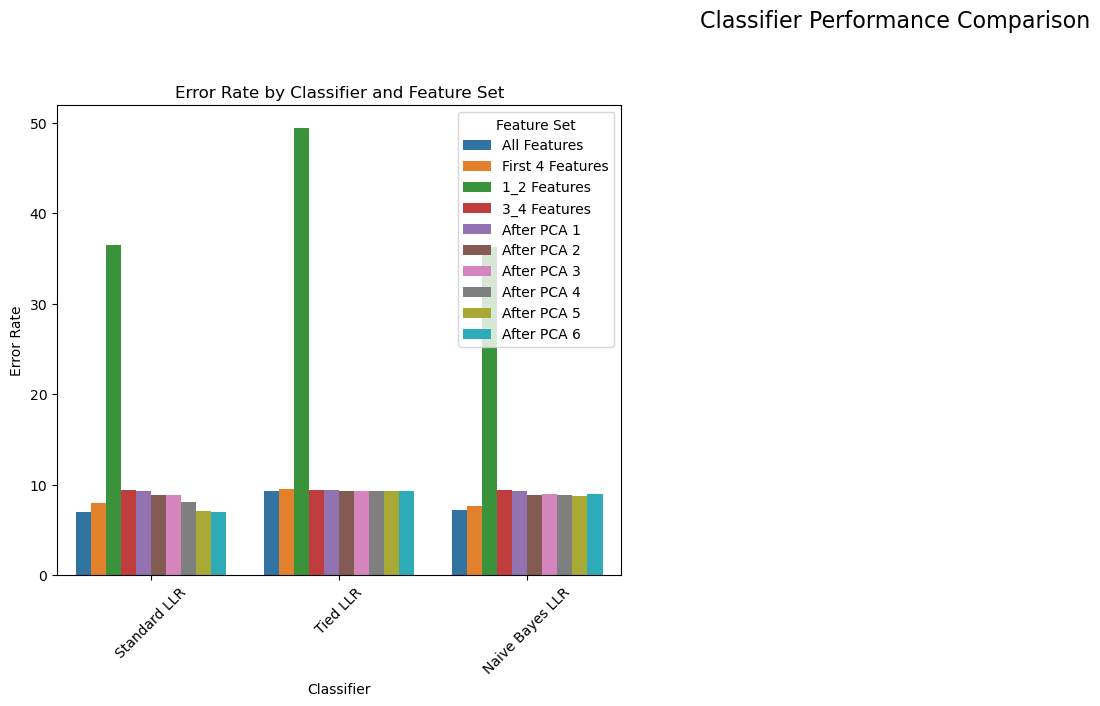

In [158]:
# Create a combined visualization comparing all methods across feature sets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
all_data = []
for result_set, feature_set in [(full_results, "All Features"), (subset_results4, "First 4 Features"),
                                (subset_results1_2, "1_2 Features"), (subset_results3_4, "3_4 Features"),
                                *pca_results]:
    for clf in result_set['classifiers']:
        name =  clf['name']
        error_rate = clf['error_rate']*100

        all_data.append({
            'Feature Set': feature_set,
            'Classifier': name,
            'Error Rate': error_rate,
        })

# Convert to DataFrame for easier plotting
results_df = pd.DataFrame(all_data)

print(results_df)

# Set up figure for multiple metrics
plt.figure(figsize=(18, 12))

# Plot each metric
metrics = ['Error Rate']

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='Classifier', y=metric, hue='Feature Set', data=results_df)
    plt.title(f'{metric} by Classifier and Feature Set')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle('Classifier Performance Comparison', fontsize=16)
plt.show()



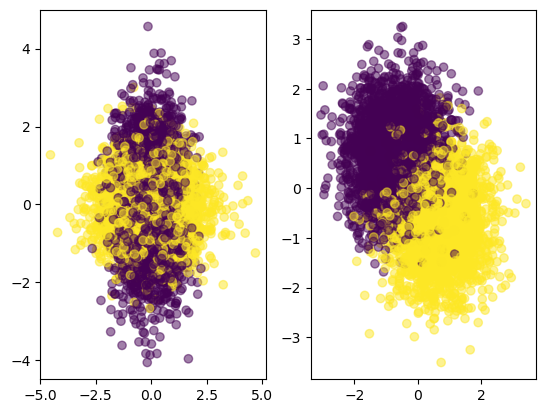

In [103]:
plt.subplots(1, 2)
# plt.scatter(D[0, (L == 0)], D[1, (L == 0)], c=L[(L == 0)])

plt.subplot(121)
plt.scatter(D[0, :], D[1, :], c=L[:], alpha=0.5)
plt.subplot(122)
plt.scatter(D[2, :], D[3, :], c=L[:], alpha=0.5)


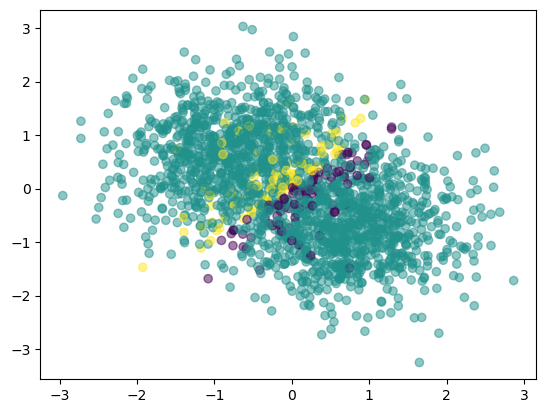

In [159]:
def llr_tied_test_1_2(D, L, show_plots=True):
    (DTR, LTR), (DVAL, LVAL) = split_train(D, L, 2.0/3.0, seed=0)

    def params_func(DTR, LTR):
        params_by_class = []
        C_tied = np.zeros((DTR.shape[0], DTR.shape[0]))
        for l in [0, 1]:
            Dl = DTR[:, (LTR == l)]
            U = Dl.mean(axis=1, keepdims=True)
            z = Dl - U
            C_tied += z @ z.T
            params_by_class.append((U, 0))
        C_tied = C_tied / DTR.shape[1]
        for l in range(len(params_by_class)):
            params_by_class[l] = (params_by_class[l][0], C_tied)
        return params_by_class
    [(mu0, C0), (mu1, C1)] = params_func(DTR, LTR)

    llr = logpdf_GAU_ND(DVAL, mu1, C1) - logpdf_GAU_ND(DVAL, mu0, C0)
    classes = np.unique(LTR)

    t = -np.log(1/2/(1/2))

    # Predict labels based on the threshold
    predictions = np.zeros_like(LVAL)
    predictions[llr > t] = 1


    plt.scatter(DVAL[0, :], DVAL[1, :], c=LVAL-predictions, alpha=0.5)
llr_tied_test_1_2(D[2:4, :], L)

In [160]:
def vcol(x):
    return x.reshape(-1, 1)
def vrow(x):
    return x.reshape(1, -1)

(_, C) = calc_params(DTR[:, (LTR == 0)])
Corr0 = C / ( vcol(C.diagonal()**0.5) * vrow(C.diagonal()**0.5) )

(_, C) = calc_params(DTR[:, (LTR == 1)])
Corr1 = C / ( vcol(C.diagonal()**0.5) * vrow(C.diagonal()**0.5) )



# Correlation Matrix Comparison

Let's visualize and compare the correlation matrices between class 0 and class 1 to understand feature relationships.

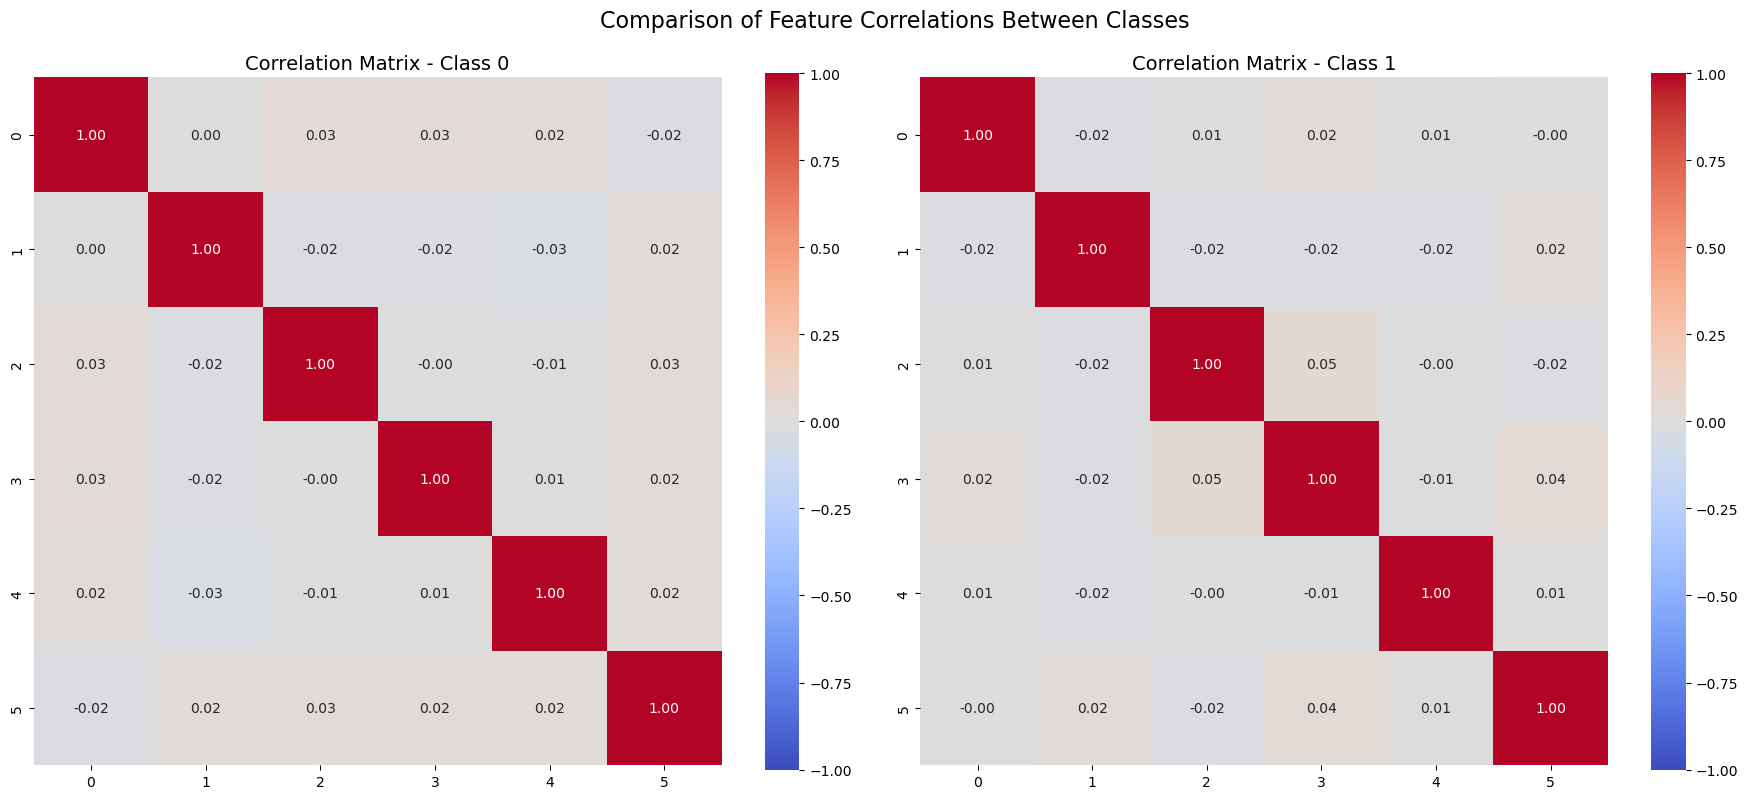

In [161]:
# Visualize correlation matrices for both classes
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr_matrices(corrs):
        

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Plot correlation matrix for class 0
    sns.heatmap(corrs[0], annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, ax=ax1, square=True)
    ax1.set_title('Correlation Matrix - Class 0', fontsize=14)

    # Plot correlation matrix for class 1
    sns.heatmap(corrs[1], annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, ax=ax2, square=True)
    ax2.set_title('Correlation Matrix - Class 1', fontsize=14)

    # Add a colorbar label
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle('Comparison of Feature Correlations Between Classes', fontsize=16)
    plt.show()

plot_corr_matrices([Corr0, Corr1])

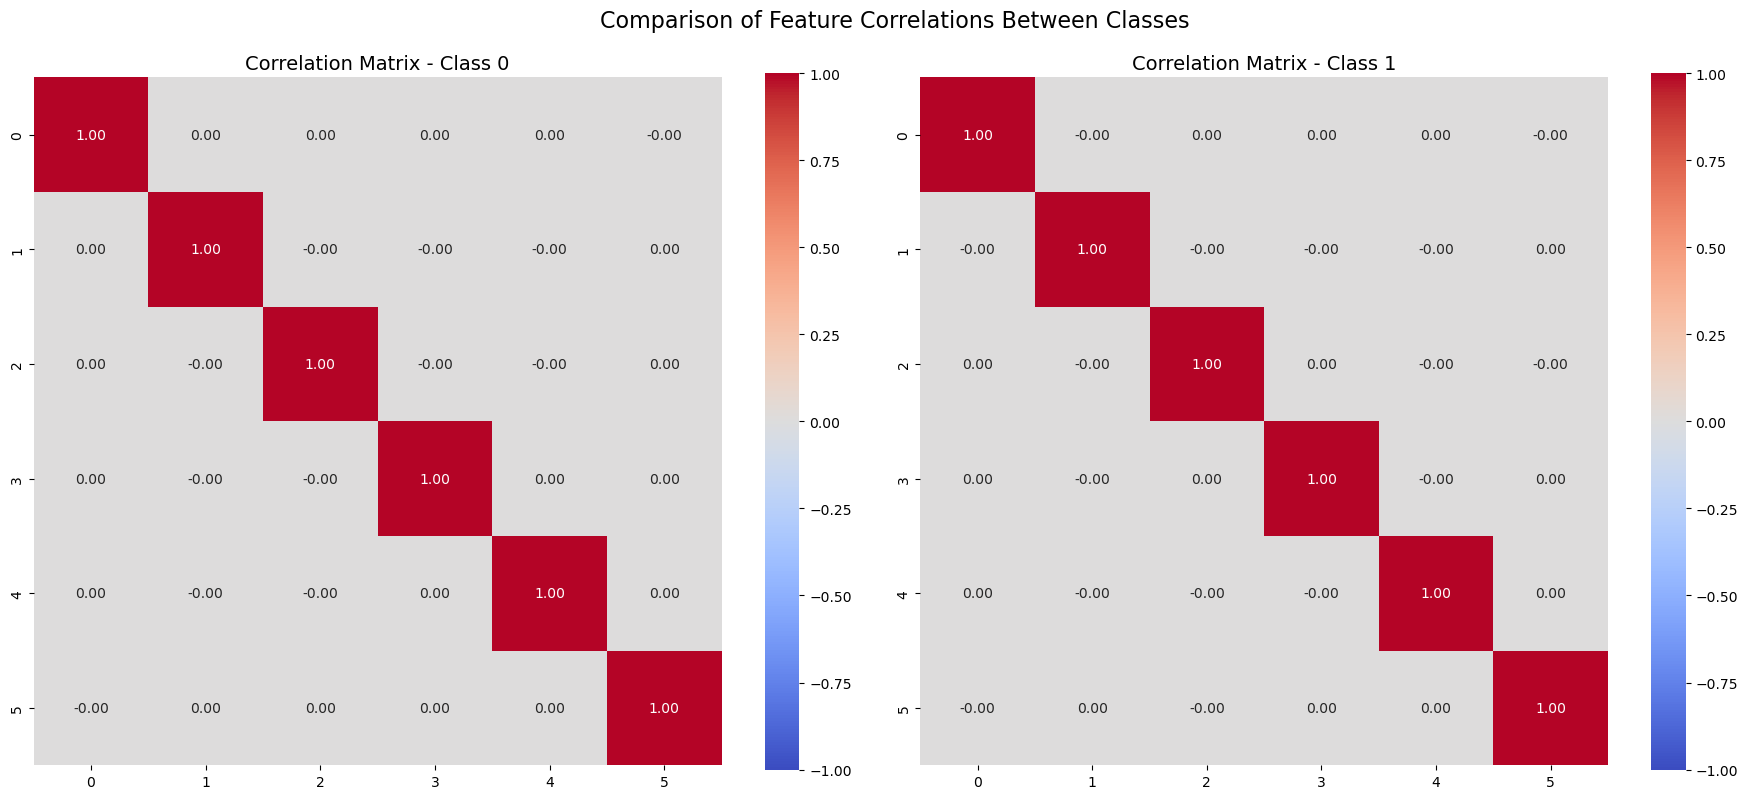

In [162]:
def calc_params_naive(D):
        U = D.mean(axis=1, keepdims=True)
        z = D - U
        C = z @ z.T / D.shape[1]

        return U, C * np.eye(C.shape[0])
    
(mu0, C0) = calc_params_naive(DTR[:, (LTR == 0)])
(mu1, C1) = calc_params_naive(DTR[:, (LTR == 1)])

Corr0naive = C0 / ( vcol(C0.diagonal()**0.5) * vrow(C0.diagonal()**0.5) )
Corr1naive = C1 / ( vcol(C1.diagonal()**0.5) * vrow(C1.diagonal()**0.5) )

plot_corr_matrices([Corr0naive, Corr1naive])




# Comparing Regular vs Naive Correlation Matrices

Let's analyze the difference between regular correlation matrices and naive correlation matrices (diagonal only) to understand the impact of the naive Bayes assumption.

Class 0 - Average absolute correlation difference: 0.0160
Class 0 - Maximum absolute correlation difference: 0.0337
Class 1 - Average absolute correlation difference: 0.0147
Class 1 - Maximum absolute correlation difference: 0.0489

Class 0 - Top 5 feature pairs with largest correlation differences:
  Features 0 and 3: 0.0337
  Features 0 and 2: 0.0327
  Features 2 and 5: 0.0271
  Features 1 and 4: -0.0264
  Features 1 and 5: 0.0230

Class 1 - Top 5 feature pairs with largest correlation differences:
  Features 2 and 3: 0.0489
  Features 3 and 5: 0.0406
  Features 1 and 2: -0.0202
  Features 1 and 5: 0.0192
  Features 0 and 3: 0.0173


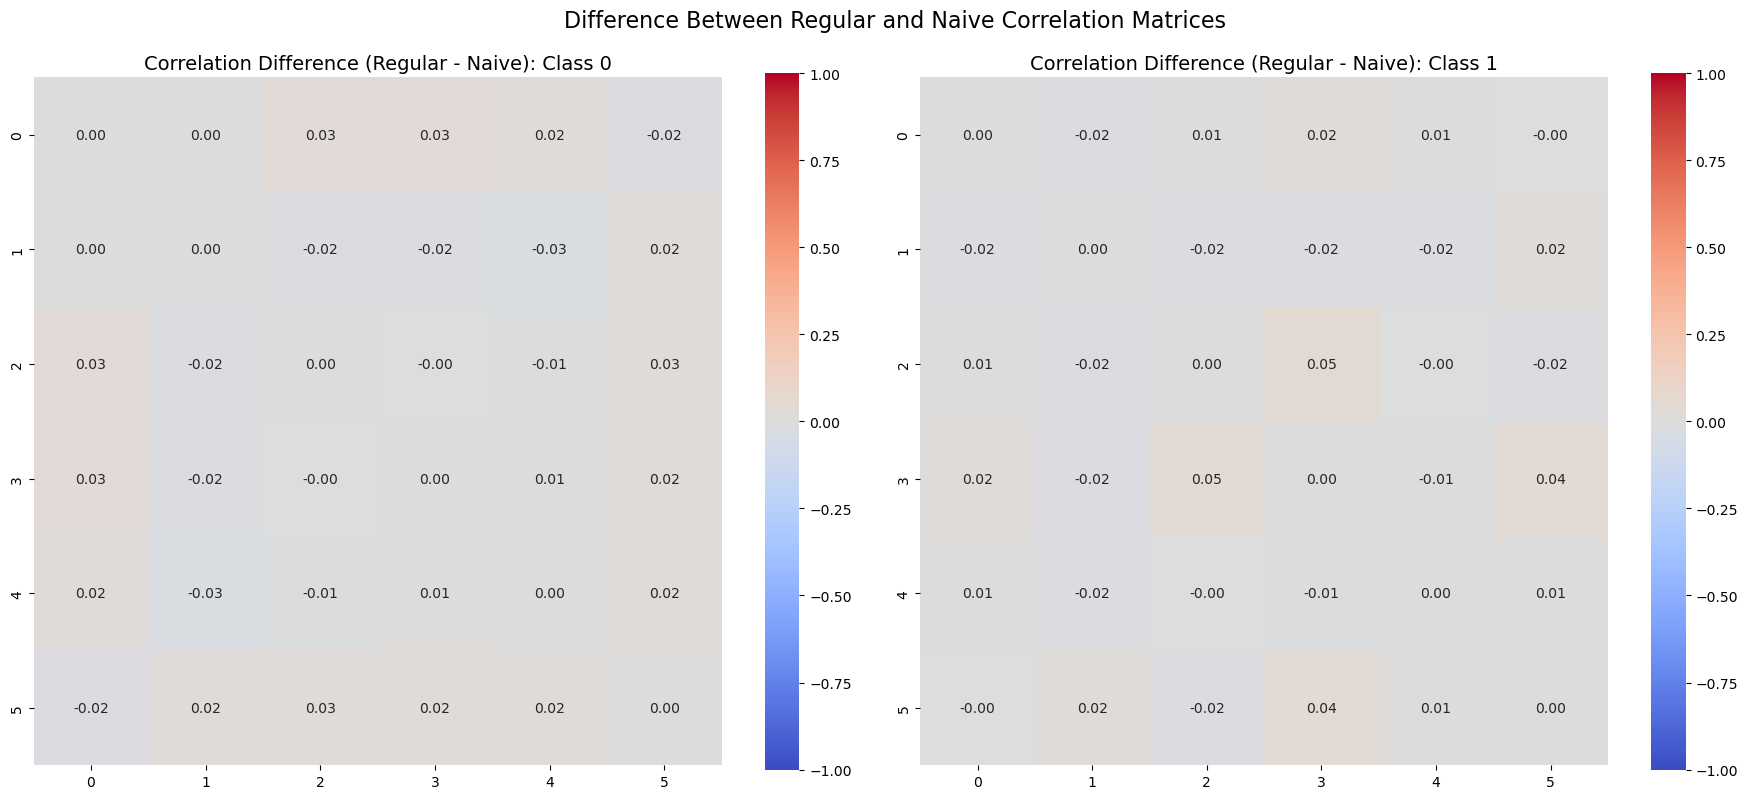

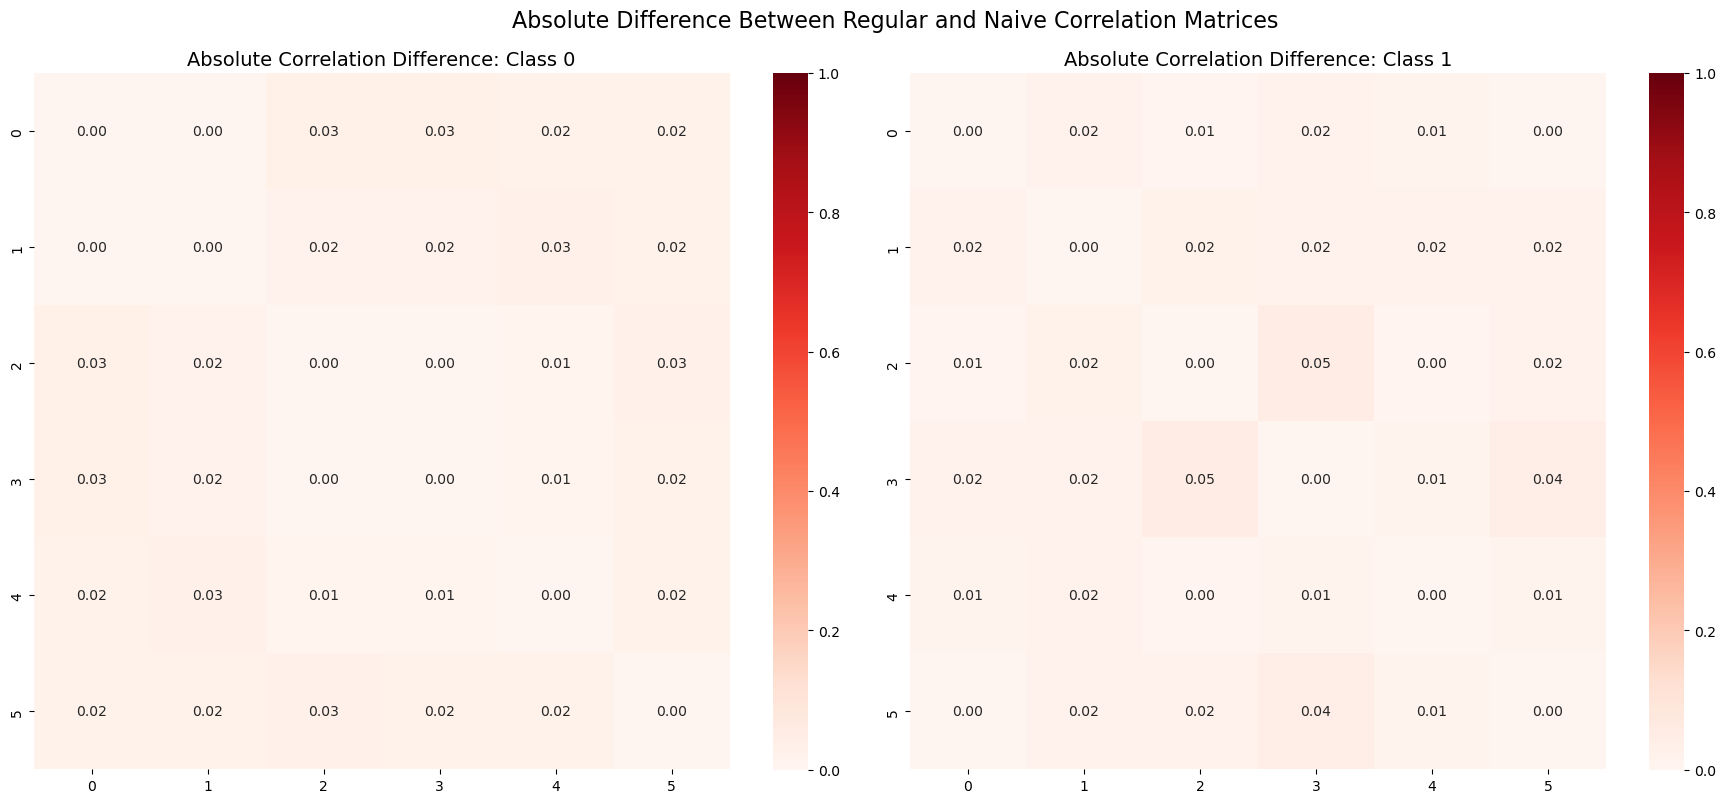

In [163]:
# Calculate the difference between regular and naive correlation matrices
corr_diff_class0 = Corr0 - Corr0naive
corr_diff_class1 = Corr1 - Corr1naive

# Set up a figure with 1x2 subplot layout for the differences
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot correlation difference matrix for class 0
im1 = sns.heatmap(corr_diff_class0, annot=True, fmt='.2f', cmap='coolwarm', 
                  vmin=-1, vmax=1, ax=ax1, square=True)
ax1.set_title('Correlation Difference (Regular - Naive): Class 0', fontsize=14)

# Plot correlation difference matrix for class 1
im2 = sns.heatmap(corr_diff_class1, annot=True, fmt='.2f', cmap='coolwarm', 
                 vmin=-1, vmax=1, ax=ax2, square=True)
ax2.set_title('Correlation Difference (Regular - Naive): Class 1', fontsize=14)

# Add a colorbar label
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Difference Between Regular and Naive Correlation Matrices', fontsize=16)

# Create a figure to show absolute magnitude of differences
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(18, 8))

# Plot absolute correlation difference matrix for class 0
im3 = sns.heatmap(np.abs(corr_diff_class0), annot=True, fmt='.2f', cmap='Reds', 
                  vmin=0, vmax=1, ax=ax3, square=True)
ax3.set_title('Absolute Correlation Difference: Class 0', fontsize=14)

# Plot absolute correlation difference matrix for class 1
im4 = sns.heatmap(np.abs(corr_diff_class1), annot=True, fmt='.2f', cmap='Reds', 
                 vmin=0, vmax=1, ax=ax4, square=True)
ax4.set_title('Absolute Correlation Difference: Class 1', fontsize=14)

# Add a colorbar label
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig2.suptitle('Absolute Difference Between Regular and Naive Correlation Matrices', fontsize=16)

# Calculate summary statistics for the differences
diff_stats = {
    'class0_mean_abs_diff': np.mean(np.abs(corr_diff_class0)),
    'class0_max_abs_diff': np.max(np.abs(corr_diff_class0)),
    'class1_mean_abs_diff': np.mean(np.abs(corr_diff_class1)),
    'class1_max_abs_diff': np.max(np.abs(corr_diff_class1))
}

print(f"Class 0 - Average absolute correlation difference: {diff_stats['class0_mean_abs_diff']:.4f}")
print(f"Class 0 - Maximum absolute correlation difference: {diff_stats['class0_max_abs_diff']:.4f}")
print(f"Class 1 - Average absolute correlation difference: {diff_stats['class1_mean_abs_diff']:.4f}")
print(f"Class 1 - Maximum absolute correlation difference: {diff_stats['class1_max_abs_diff']:.4f}")

# Identify the feature pairs with the largest correlation differences
def get_top_diff_pairs(diff_matrix, n=5):
    # Create a mask for the upper triangle excluding diagonal
    mask = np.triu(np.ones_like(diff_matrix), k=1).astype(bool)
    # Get the upper triangle values and their indices
    abs_diff_vals = np.abs(diff_matrix)[mask]
    indices = np.argwhere(mask)
    # Get the top n differences
    top_indices = np.argsort(-abs_diff_vals)[:n]
    feature_pairs = [(indices[i][0], indices[i][1]) for i in top_indices]
    diff_values = [diff_matrix[i, j] for i, j in feature_pairs]
    return feature_pairs, diff_values

# Get top different feature pairs
top_pairs_class0, top_diffs_class0 = get_top_diff_pairs(corr_diff_class0)
top_pairs_class1, top_diffs_class1 = get_top_diff_pairs(corr_diff_class1)

print("\nClass 0 - Top 5 feature pairs with largest correlation differences:")
for (i, j), diff in zip(top_pairs_class0, top_diffs_class0):
    print(f"  Features {i} and {j}: {diff:.4f}")

print("\nClass 1 - Top 5 feature pairs with largest correlation differences:")
for (i, j), diff in zip(top_pairs_class1, top_diffs_class1):
    print(f"  Features {i} and {j}: {diff:.4f}")